### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 2048
blocklen = (blocklenk * 1024)

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 1,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [6]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 1
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

This generation of ld-decode uses FFT multiplication to perform convolutions. This allows multiple filter types to be "stacked" into a minimal number of general operations.

In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['Fvideo_lpf05'] = filtfft(sps.butter(SP['vlpf_order'], 0.5/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']
    SP['FVideo05'] = SP['Fvideo_lpf05'] * SP['Fdeemp']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [11]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data1)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    tdangles2[tdangles2 < 0] += tau
    tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

    return output

In [12]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [13]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [14]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [15]:
# nice GGV sample (40msps)
#infile = open('ggv1069_22000.raw', 'rb')

# discovision logo (rotted :P )
#infile = infile = open('/home/cpage/erica_44a.raw', 'rb')
#infile.seek(1024 * 1024 * 1400)

infile = infile = open('/home/cpage/ve22_44zonea.raw', 'rb')

inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [16]:
blockcut = 1024

params['freq'] = 44.0
filterset = prepare_video_filters(params)

output = dodemod(filterset, data1, usemtf=False)


In [17]:
output

array([ 7641559.46101413,  7618261.70052184,  7536892.95052545, ...,
        7624104.59408538,  7633568.69330179,  7640650.32570267])

Below this is the less developed code to deal with NTSC framing and syncs.

In [18]:
# NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks

output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -25)))

# Perform FFT convolution of above filter
output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

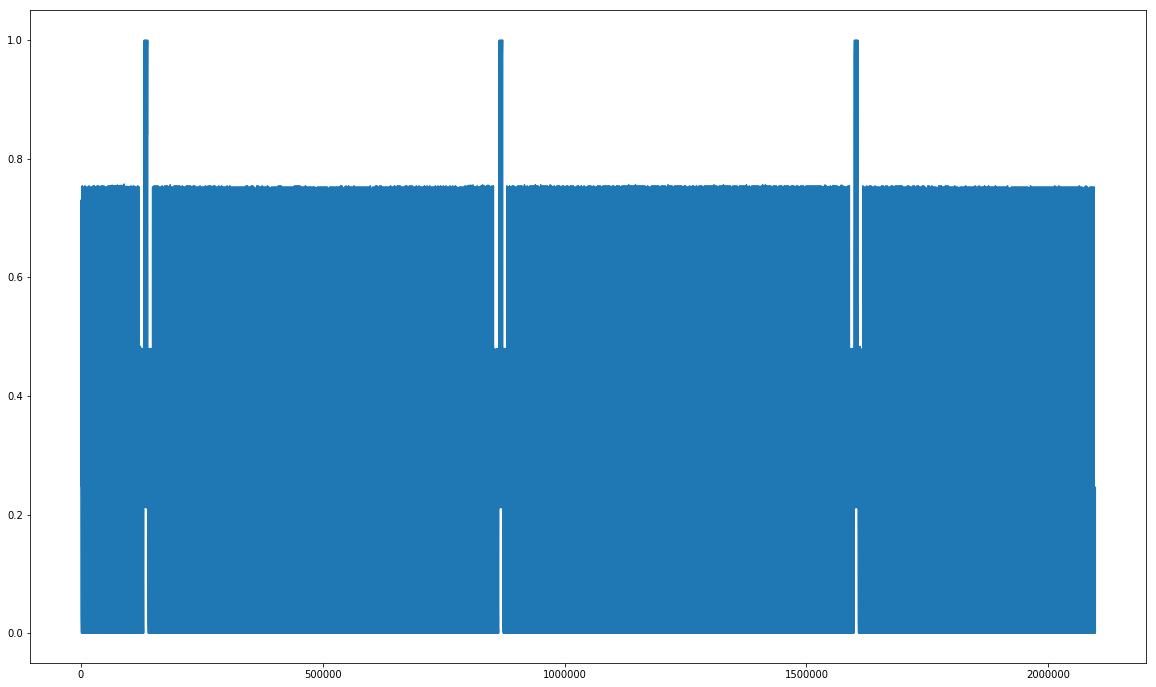

In [19]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(output_syncf)

In [20]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 400000
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_syncf):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_syncf[loc:loc+imglen]) + loc

if np.max(output_syncf[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

869178

In [21]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_syncf, syncloc)

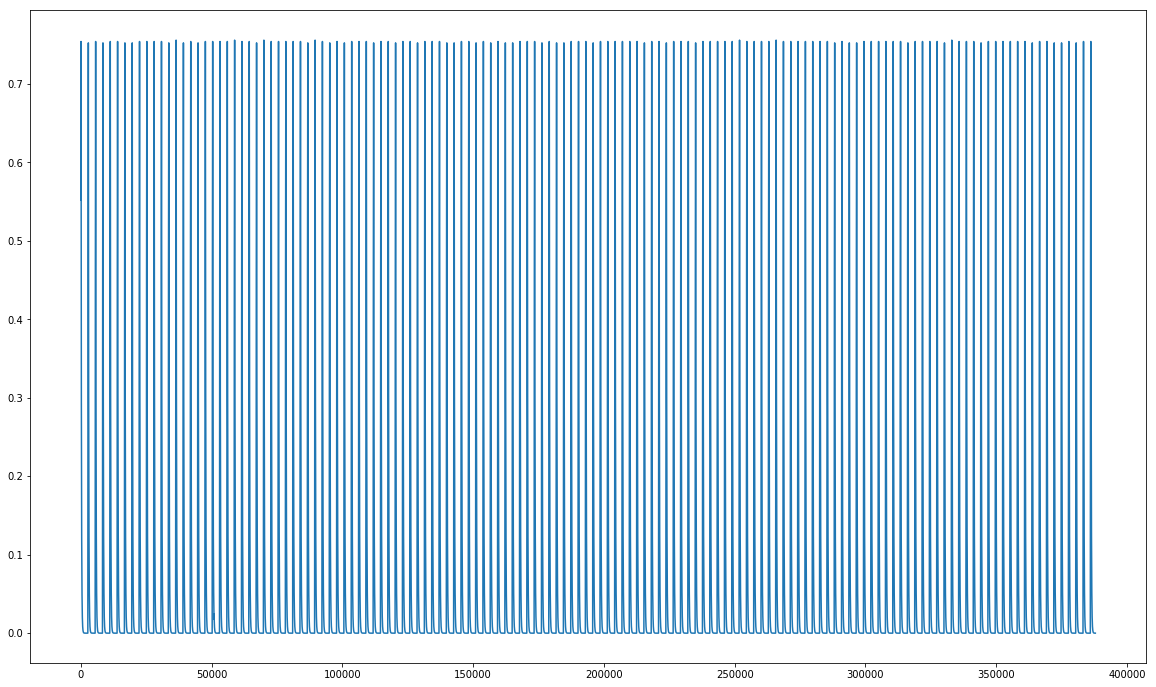

In [22]:
plt.plot(output_syncf[nextline:syncloc+399430])

In [23]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [24]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_syncf[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if ((output_syncf[curloc] < .7) and not is_validlinegap) or not validaftersync:
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    #print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

In [25]:
m20ire = 8100000-hz_ire_scale*20

In [26]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [27]:
video_05 = filtfft(sps.butter(3, 0.5/22, 'low'))
output_lp = np.fft.ifft(np.fft.fft(output) * video_05).real[29:] 

In [28]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


883575 7734615.50359 7807243.9613 7892668.41739
886372 7778439.64793 7857525.00692 7939131.46593
889168 7745454.06417 7815375.46326 7892730.04992
891965 7758319.72693 7826257.36524 7905499.47396
894762 7780207.14484 7855920.44191 7940939.69727
897558 7751481.63217 7814638.97799 7887983.28026
900355 7763543.38382 7843183.81316 7927608.35701
903152 7789939.90084 7863263.66811 7941594.67442
905949 7794480.23061 7869513.90571 7950639.61341
908745 7754131.27985 7822864.96836 7896840.10958
911542 7770790.41396 7835379.91674 7909187.82787
914338 7742794.19551 7800656.47023 7860349.37622
917136 7777562.74194 7851860.16066 7935855.09437
919932 7745295.8382 7806557.63076 7871237.22126
922730 7779588.74176 7857379.79244 7942977.49958
925526 7739057.0126 7801430.59359 7870039.0647
928324 7790327.07763 7869447.19032 7952744.78397
931120 7748115.53602 7799196.86974 7860943.08376
933918 7786366.28722 7856963.48854 7935147.47797
936715 7795856.77238 7872542.21161 7949619.53616
939512 7775867.81834 783

In [29]:
lineinfo2e = []

c = 0
for l in lineinfo:
    zc = calczc(output_lp, int(l - 10 + (filterset['line_px'] * 55 / 63.5)), m20ire, 200)
    
    if zc is None:
        lineinfo2e.append(l)
        continue
        
    lineinfo2e.append(zc)
    print(l, lineinfo2[c], lineinfo2e[c], output[l], output[l + 1], output[l + 2])
    c += 1
    


883575 880695 880695 7734615.50359 7807243.9613 7892668.41739
886372 883576.266328 886174.931167 7778439.64793 7857525.00692 7939131.46593
889168 886372.787937 888971.653431 7745454.06417 7815375.46326 7892730.04992
891965 889169.091564 891768.1298 7758319.72693 7826257.36524 7905499.47396
894762 891965.609937 894564.535198 7780207.14484 7855920.44191 7940939.69727
897558 894762.330061 897361.54207 7751481.63217 7814638.97799 7887983.28026
900355 897558.828526 900158.050756 7763543.38382 7843183.81316 7927608.35701
903152 900355.684342 902954.774218 7789939.90084 7863263.66811 7941594.67442
905949 903152.657337 905751.339414 7794480.23061 7869513.90571 7950639.61341
908745 905949.13906 908548.156241 7754131.27985 7822864.96836 7896840.10958
911542 908746.310896 911346.221862 7770790.41396 7835379.91674 7909187.82787
914338 911542.957636 914142.663832 7742794.19551 7800656.47023 7860349.37622
917136 914339.695606 916938.996449 7777562.74194 7851860.16066 7935855.09437
919932 917136.5332

1233303 1230505.63716 1233107.26883 7779248.30496 7856182.68139 7934442.24423
1236101 1233303.9388 1235905.07099 7761080.58696 7838420.09382 7922274.05589
1238899 1236102.18995 1238703.40194 7740680.01892 7797678.33098 7866642.20419
1241697 1238900.34162 1241501.65481 7735460.40285 7802962.1212 7880196.397
1244495 1241698.56905 1244299.63953 7749844.22296 7804117.79968 7868097.41654
1247294 1244496.4736 1247098.06378 7769557.73443 7827691.03708 7895652.41379
1250092 1247294.94017 1249896.33068 7776081.92756 7832777.53815 7897081.15371
1252890 1250093.11441 1252694.64711 7736548.52112 7815799.02747 7904243.80952
1255688 1252891.02918 1255492.66855 7740126.13819 7807275.14068 7886753.40124
1258487 1255689.24319 1258290.72626 7788527.87811 7869351.67986 7954589.43299
1261285 1258487.48298 1261088.85544 7778818.93873 7852993.13801 7933529.22048
1264083 1261285.39547 1263887.30168 7745128.80747 7827383.2691 7919106.15423
1266881 1264083.94872 1266685.46635 7765998.69626 7825225.3536 7894481

In [30]:
# experiment:  filter color burst data for easier alignment

In [31]:
video_cburst = filtfft(sps.butter(2, [(300/88.0)/22, (330/88.0)/22], 'bandpass'))


In [32]:
output_cburst = np.fft.ifft(np.fft.fft(output - 8100000) * video_cburst).real[98:] + 8100000

In [33]:
calczc(output_lp, int(lineinfo2[250])-80, m20ire, 200), calczc(output, int(lineinfo2[250])-80, m20ire, 200)

(1580252.1782632936, 1580252.430185965)

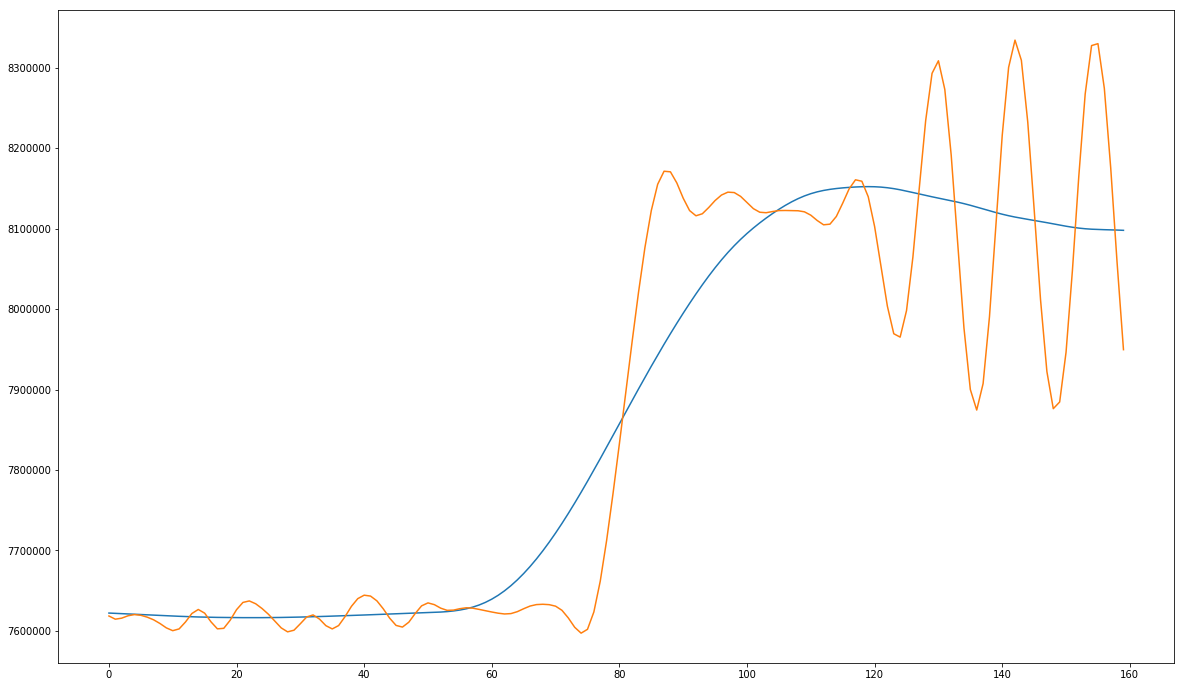

In [34]:
plt.plot(output_lp[int(lineinfo2[250]-80):int(lineinfo2[250])+80])
plt.plot(output[int(lineinfo2[250])-80:int(lineinfo2[250])+80])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

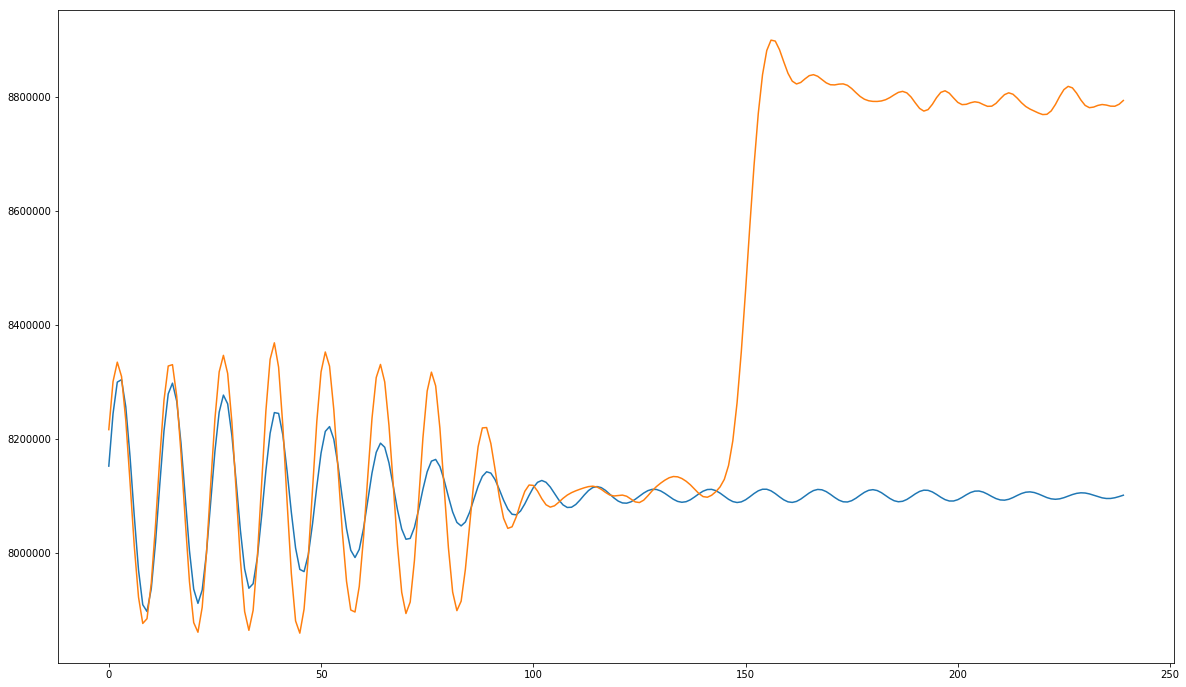

In [35]:
plt.plot(output_cburst[int(lineinfo2[250]+60):int(lineinfo2[250])+300])
plt.plot(output[int(lineinfo2[250])+60:int(lineinfo2[250])+300])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

In [36]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


883575 7734615.50359 7807243.9613 7892668.41739
886372 7778439.64793 7857525.00692 7939131.46593
889168 7745454.06417 7815375.46326 7892730.04992
891965 7758319.72693 7826257.36524 7905499.47396
894762 7780207.14484 7855920.44191 7940939.69727
897558 7751481.63217 7814638.97799 7887983.28026
900355 7763543.38382 7843183.81316 7927608.35701
903152 7789939.90084 7863263.66811 7941594.67442
905949 7794480.23061 7869513.90571 7950639.61341
908745 7754131.27985 7822864.96836 7896840.10958
911542 7770790.41396 7835379.91674 7909187.82787
914338 7742794.19551 7800656.47023 7860349.37622
917136 7777562.74194 7851860.16066 7935855.09437
919932 7745295.8382 7806557.63076 7871237.22126
922730 7779588.74176 7857379.79244 7942977.49958
925526 7739057.0126 7801430.59359 7870039.0647
928324 7790327.07763 7869447.19032 7952744.78397
931120 7748115.53602 7799196.86974 7860943.08376
933918 7786366.28722 7856963.48854 7935147.47797
936715 7795856.77238 7872542.21161 7949619.53616
939512 7775867.81834 783

In [37]:
# now to get fine sync!

In [38]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    

x = np.arange(0, 400)
scale(x, 50.5, 60.5, 10)

array([ 50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5])

In [40]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
#        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

#lines, sfactor = downscale(output_cburst, lineinfo3)
    
#reduced = (lines - minn) / hz_ire_scale
#lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


In [41]:
#drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [42]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [43]:
def calcerr(line):
    subset = line[5:60]
    
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [44]:
910 * 1.2

1092.0

In [45]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
finalsnr = []

# because of odd issues, it makes sense to do one line and the next burst together, and so on...
for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        scaled = scale(output_cburst, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        offset1 = calcerr(scaled[0:60])
        offset2 = calcerr(scaled[910:970])
        print(l, i, offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if (i == 0):
            lineinfo_tmp[l + 1] -= ((offset2 - offset1) * (linelen / 910) * (.5 / (i + 1)))
        else:
            lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
            lineinfo_tmp[l + 1] -= ((offset2) * (linelen / 910) * (.5 / (i + 1)))
            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 0.234741128126 0.2884569552 45.7008629023
1 1 0.23546653496 0.312412134596 43.3434229974
1 2 0.291142375473 0.178398904509 41.8462274517
1 3 0.334495995847 0.068426753636 43.2697293864
1 4 0.0775215528961 0.047787071568 46.2071007523
1 f 0.0691618753961 -0.00392858675354 36.6379407509
2 0 0.0503173271966 0.242631362618 45.6702514846
2 1 0.0521405201146 0.0051626763903 51.7875913064
2 2 0.0382639321341 0.00597341444846 54.0974321832
2 3 0.0267502115827 0.00666798643719 55.0435552659
2 4 0.00630997363376 0.00728696079836 55.4047140594
2 f -0.012062028905 -0.0466390681737 37.5903951137
3 0 0.0060109169092 0.0262182812013 52.4717609014
3 1 0.00620183310159 0.0345871010245 55.4493800812
3 2 0.00757546906014 0.0416830101277 58.1298456497
3 3 0.00869155197399 0.0241283621742 60.5584259917
3 4 0.00959554441242 0.00583462732472 61.3354760588
3 f -0.044795679455 0.0336136586155 39.3302312462
4 0 0.00592748201554 0.128072813863 44.0728250403
4 1 0.00708226150349 0.0319632561313 53.5685990473


38 0 -0.000361367422578 0.27816745567 36.1684191095
38 1 0.00218768744028 0.0682533466787 44.0823593224
38 2 0.0029245853528 0.0310583039973 45.4748581368
38 3 0.00339773065981 0.0187474084241 45.8792134911
38 4 0.00377030573634 0.0206744012689 46.044701766
38 f 0.0118835214535 0.0322220351747 38.9742417005
39 0 0.0201569297745 0.317191530589 40.5128931586
39 1 0.0229090109594 -0.00464051474269 46.0482371825
39 2 0.0273884996828 -0.00569300130957 46.4235938446
39 3 0.0309497440789 -0.0065520097165 46.6775866153
39 4 0.0116966320487 -0.00729246041704 46.8536748699
39 f 0.0459937521103 0.0524533311155 37.5741972723
40 0 0.032728770344 0.273382721744 36.6141782224
40 1 0.0128273989416 0.110661201895 42.9753788322
40 2 -0.00616001525021 0.0457520549696 44.657368427
40 3 -0.00682128895017 0.0521289358059 45.2322070207
40 4 -0.00736730377246 0.0575549046175 45.6908188219
40 f 0.0523315793646 0.0556502521488 37.2900760099
41 0 0.059767574745 0.310510959058 39.9841748589
41 1 0.0386588230966 0

72 3 0.0371395999645 0.0504214373593 46.1718740898
72 4 0.0185024279102 0.0556206102581 46.3361202308
72 f 0.0394861213423 0.11875066663 38.0094894422
73 0 0.0321242874264 0.318376356736 42.1598545566
73 1 0.0348491934435 0.0141494987807 47.7177264629
73 2 0.0418269763352 -0.0039473056297 48.2915246356
73 3 0.0209808493819 -0.00461207894616 49.1226552589
73 4 0.0230394252966 -0.00513079487485 49.4558339248
73 f 0.036349280372 -0.00326681052005 39.7859188424
74 0 0.0114543833377 0.248106528761 35.516257845
74 1 0.013587526171 0.202454522829 41.2150063595
74 2 -0.00369785664004 0.0418215458128 44.7163835592
74 3 -0.00405013820985 0.0476629251188 45.3439266973
74 4 -0.00433530944848 0.0526352911369 45.8797971312
74 f -0.00242177298568 0.0877249361677 40.1069195555
75 0 0.0521821301477 0.179281280446 34.8542898922
75 1 0.0534243546795 0.248102042687 37.2409280002
75 2 0.000251057887329 0.30483699282 39.5956136768
75 3 0.00124184309733 0.350816352077 42.770770581
75 4 0.00219037955543 0.114

111 3 0.0315252789355 -0.0146579114646 41.1335017917
111 4 0.0345999836517 0.0220114121417 41.4287284597
111 f 0.0465018508069 -0.0792507364054 38.2028743284
112 0 0.000154163771364 0.324988212994 37.0121948334
112 1 -0.0145883733339 -0.00512797469582 46.3807817287
112 2 0.0207956512852 -0.00610188061863 46.4850477436
112 3 -0.0147697633957 -0.00698764887501 46.2751104494
112 4 0.0220107764527 -0.00766297033111 46.3213763536
112 f -0.079377856089 -0.0550624124463 39.0389372674
113 0 -0.0123634374485 0.263314586652 35.9756570157
113 1 -0.00991253403738 0.0807973744428 43.9177728709
113 2 -0.0114768880288 0.0423026077266 46.1576888198
113 3 -0.0128370810834 0.0482247966546 47.1590389679
113 4 -0.0139767452082 0.0532672282208 48.0553492585
113 f -0.0400154404703 0.0310236604061 36.5958858133
114 0 0.0561253595699 0.310833935831 40.0864992932
114 1 0.0586098540071 0.035180377195 53.8061764866
114 2 0.0225803543343 0.0199979782469 53.3650032652
114 3 0.0255891100411 0.0226658843748 53.32248

149 0 0.0293380381173 0.201845801573 36.5850347233
149 1 0.0309983618774 0.290138290853 41.2276354255
149 2 0.0386163378179 0.300655454671 47.1436191664
149 3 -0.0024731318412 0.0365430472275 51.3879075576
149 4 -0.00263291530068 0.0403790537537 51.414725865
149 f 0.0234710992889 0.0648741783977 33.8964425457
150 0 0.038914538116 0.159532941018 34.2690516509
150 1 0.0401056924622 0.227352281185 36.445183373
150 2 0.0491954257495 0.286557663532 38.6007922898
150 3 0.0566093476385 0.33081187556 40.9128059774
150 4 0.037698890746 0.128775014188 43.4422820904
150 f -0.00101424843537 0.177149024509 36.7836647623
151 0 0.135894694426 0.141911467724 35.1697134951
151 1 0.135955610642 0.145617499326 35.2723741443
151 2 0.0418782787505 0.187585479138 35.3489779754
151 3 0.0480445565305 0.221822101508 36.2299577093
151 4 0.0533441048446 0.250586944776 37.0946660731
151 f 0.0741497281268 0.124576673067 32.9018377638
152 0 0.273128476697 0.10139744365 38.402083808
152 1 0.271132253332 -0.026710543

191 2 0.0415928337757 0.14040275495 46.5315978934
191 3 0.0236476415328 0.0767250438281 47.7604645578
191 4 0.0261564158872 0.028141286286 48.1460895803
191 f -0.0462874506902 0.0376249243637 37.124060958
192 0 0.0289474292149 0.234535540256 36.1416491494
192 1 0.0309087792245 0.334719756546 40.9011587883
192 2 0.0386372093917 0.0472051448264 45.1707992431
192 3 0.0438771134173 0.0278996890278 45.2339995271
192 4 0.0482651399363 0.030687975672 45.1629402846
192 f 0.063278217354 0.119899508147 36.4499341019
193 0 0.0291400478861 0.273807555531 38.2876873709
193 1 0.0314852959722 0.141914859497 45.6206947552
193 2 0.0383681137265 0.0491531569387 46.6495181924
193 3 0.0273273886561 0.0304218755104 46.6781628122
193 4 0.00601333189722 0.0335040897117 46.6865130004
193 f 0.0395936398425 0.173631700908 42.4148327316
194 0 0.0335173223407 0.246130535546 36.2668879807
194 1 0.0355515447589 0.347306055903 41.696212304
194 2 0.0269474252575 0.018715828884 47.4969123257
194 3 0.0305259865717 0.02

230 3 0.0328417719732 -0.0233162595982 47.9110064846
230 4 0.0359968360653 -0.0257527159592 48.3137060328
230 f 0.058744665784 -0.0304668389431 38.5240996867
231 0 -0.0142583508504 0.297138077095 37.4270583507
231 1 -0.0114748735747 0.0080199201599 46.9750495529
231 2 -0.0136672223292 0.00971275951601 47.1836752081
231 3 -0.0154089768739 0.0110776951369 47.3153940976
231 4 -0.0168825050365 0.0122440582442 47.4002400829
231 f -0.0391038324869 0.011214797269 35.7201973485
232 0 0.010631352972 0.269159767005 36.4748278376
232 1 0.0129632711624 0.081428107967 43.5569965658
232 2 0.0158579184659 0.0429063842419 44.8303512535
232 3 0.0180455061616 0.0488219583023 45.1671518243
232 4 0.0199106794563 0.0282503739271 45.4512612508
232 f 0.020387849753 0.0151385745756 34.7414806088
233 0 0.0299020320156 0.353344041854 43.6141349697
233 1 0.0329979992114 0.00211356955025 41.5312311012
233 2 0.0175081404368 0.002388958229 42.030150763
233 3 0.0198080274208 0.00265628920385 42.1965029258
233 4 0.00

37.8103992975
(230230,)
uint8 (253, 910) (253, 910)


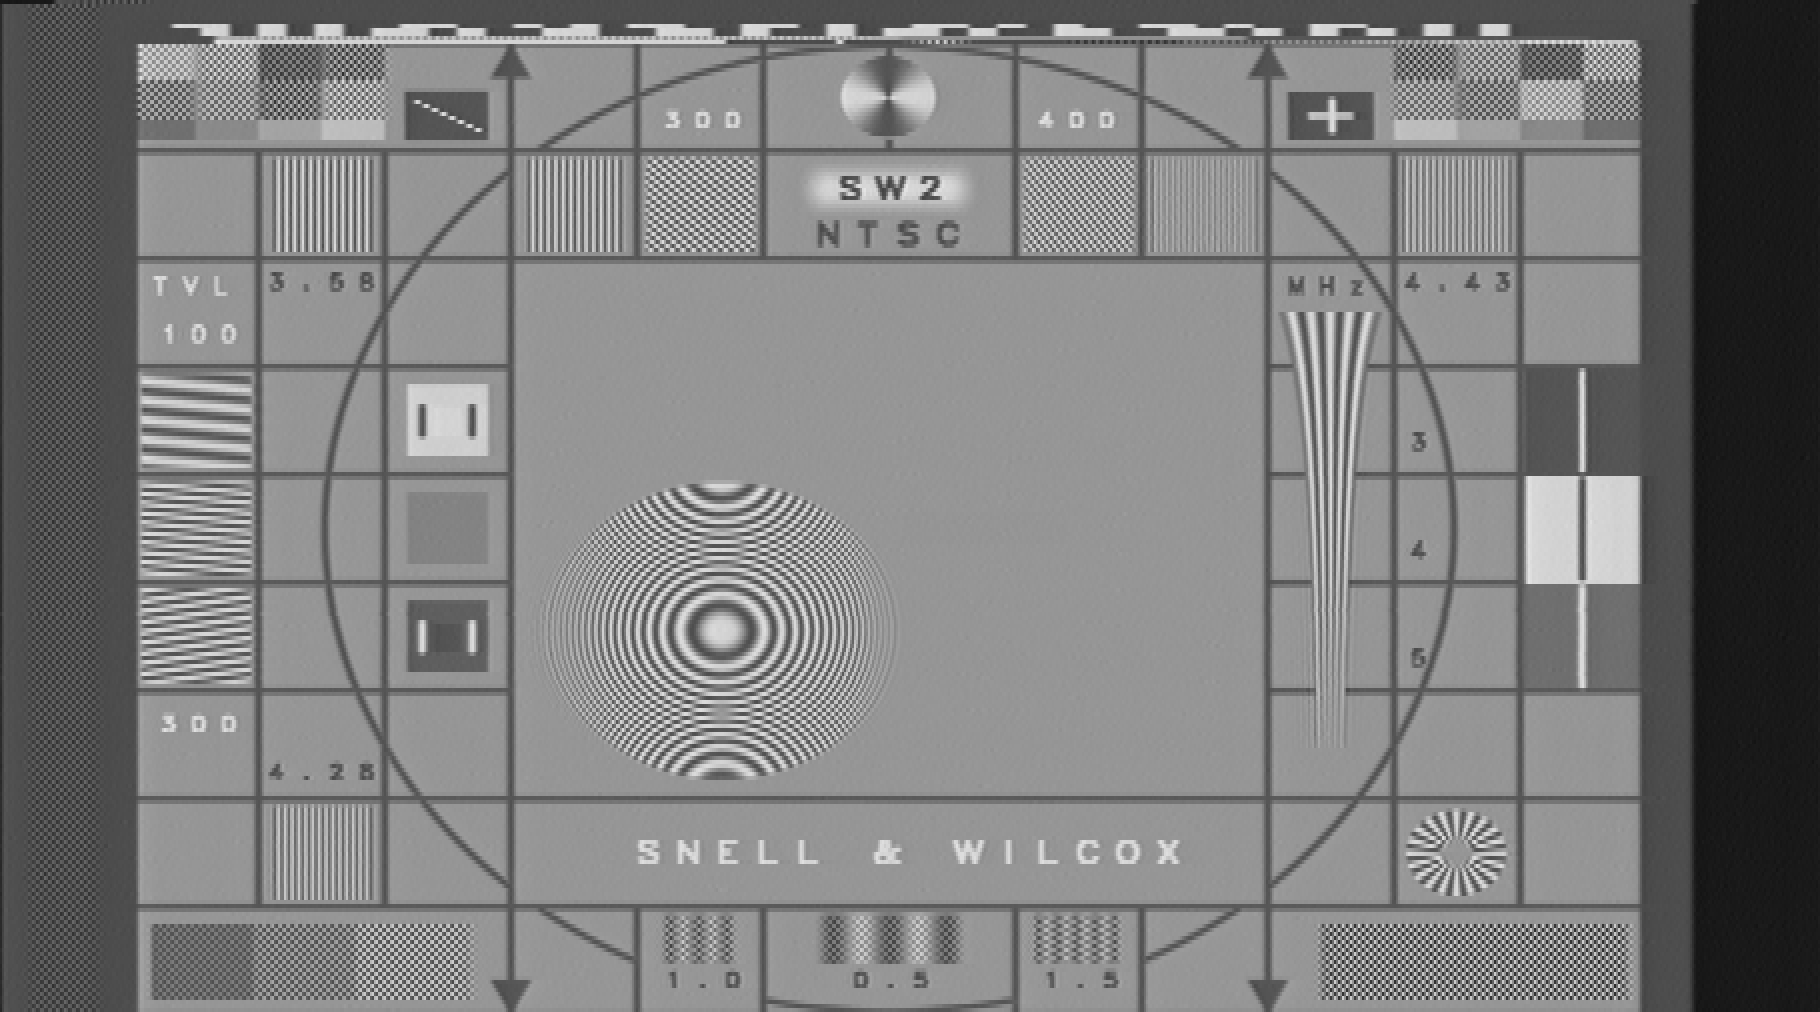

In [46]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

(230230,)
uint8 (253, 910) (253, 910)


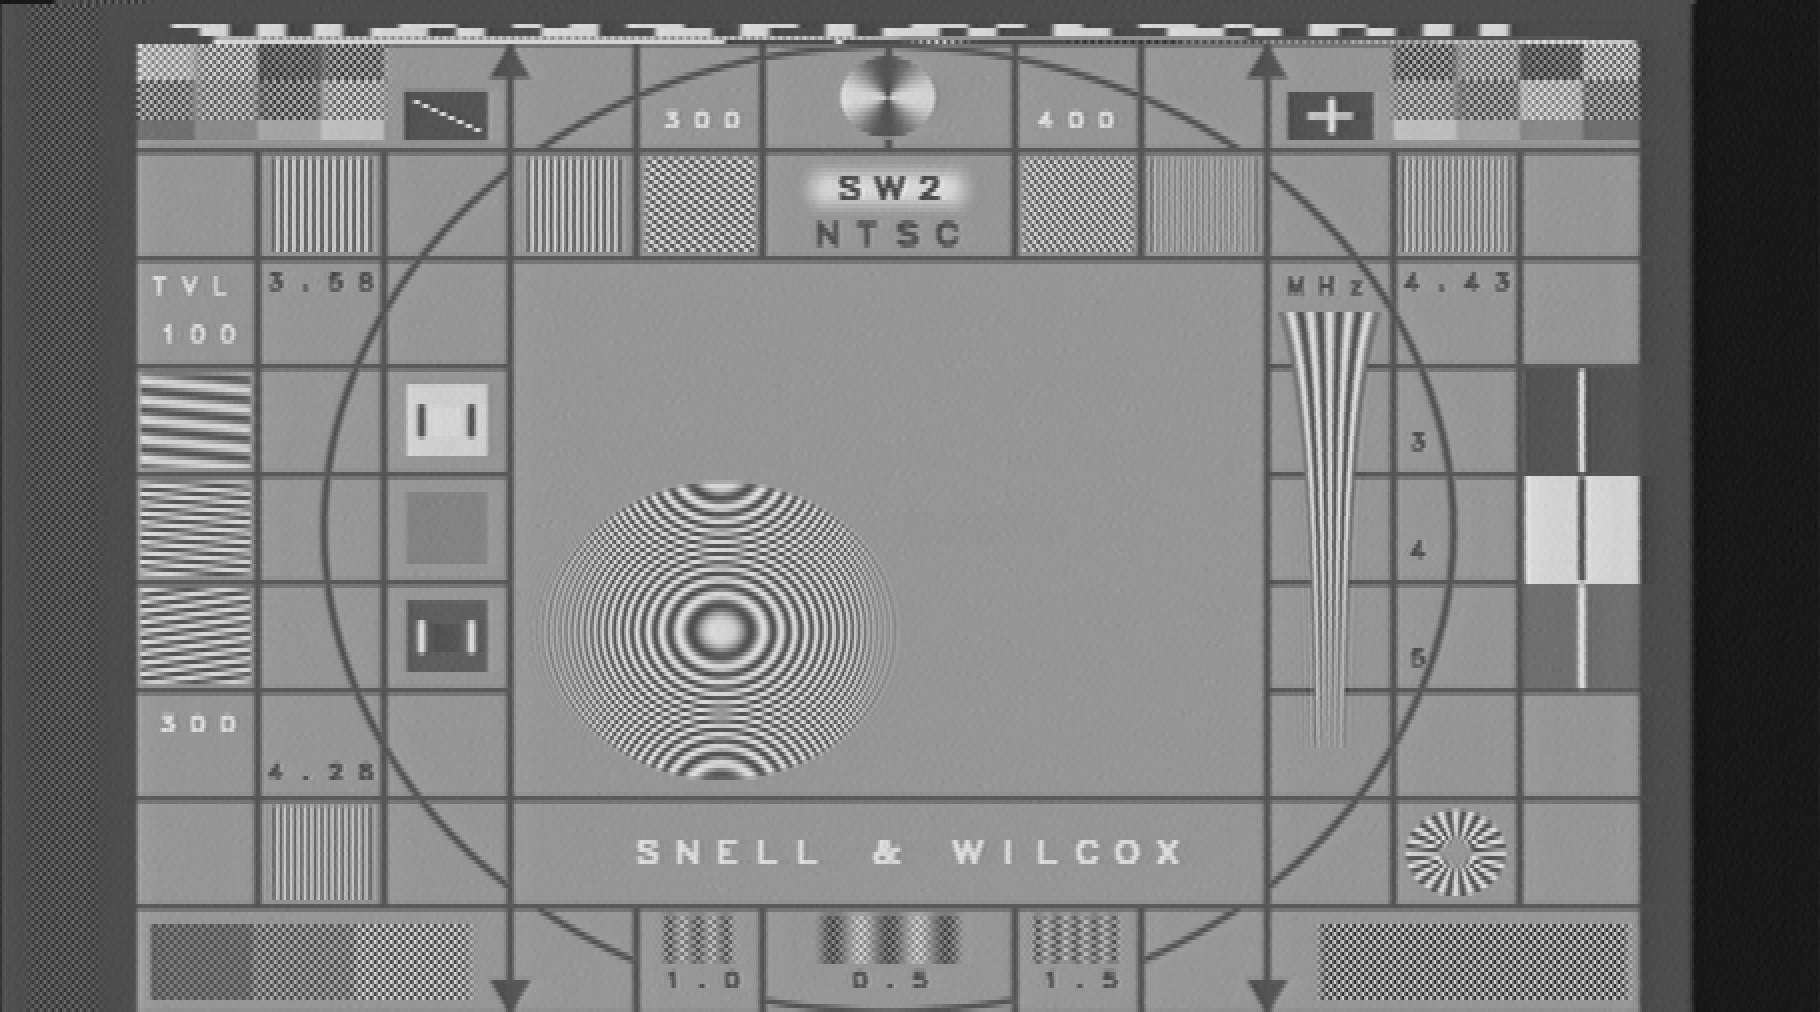

In [694]:
def downscale2(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    for l in range(0, len(lineinfo) - 1):
        scaled = scale(data, lineinfo[l][0], lineinfo[l + 1][1], 910)
        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout

lines, downscale2(output_cburst, lineinfo3)
    
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)
drawdata(lines16, 910, len(lineinfo3)-1, hscale=2, vscale=4)

In [695]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 -0.154741137918 845.368979898 909.861959977 37.4950262196
3 -0.138040022963 845.484546213 909.9074071 39.53515591
4 -0.0925929003539 845.450885029 909.909596074 38.2483850861
5 -0.0904039259235 845.431623837 909.909069945 38.7810154812
6 -0.090930054506 845.442284106 909.86090586 38.7791257511
7 -0.139094139965 845.425737295 909.832417702 39.7752201802
8 -0.167582298308 845.27221555 909.925389741 38.3505643762
9 -0.0746102585259 845.027630874 909.812592829 34.1564994399
10 -0.187407171451 845.224789305 909.883270826 38.0456201704
11 -0.116729174283 845.393663928 909.831584864 37.2948848883
12 -0.168415135823 845.195340354 909.928115571 36.7303025515
13 -0.0718844287775 845.338972519 909.837234703 36.2558223715
14 -0.162765296637 845.386983961 909.95733255 36.5790130216
15 -0.0426674502844 845.357508123 909.888763879 40.4586957605
16 -0.111236121343 845.278593138 909.928385346 37.6993434262
17 -0.0716146538122 845.114413832 909.880244413 38.2993437394
18 -0.119755586585 845.315334887 

In [696]:
np.mean(zclen), np.std(zclen)

(64.535136767752377, 0.11737262082938797)

In [697]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.062264975967787954, 0.10891155743135103, 38.206862345726094)

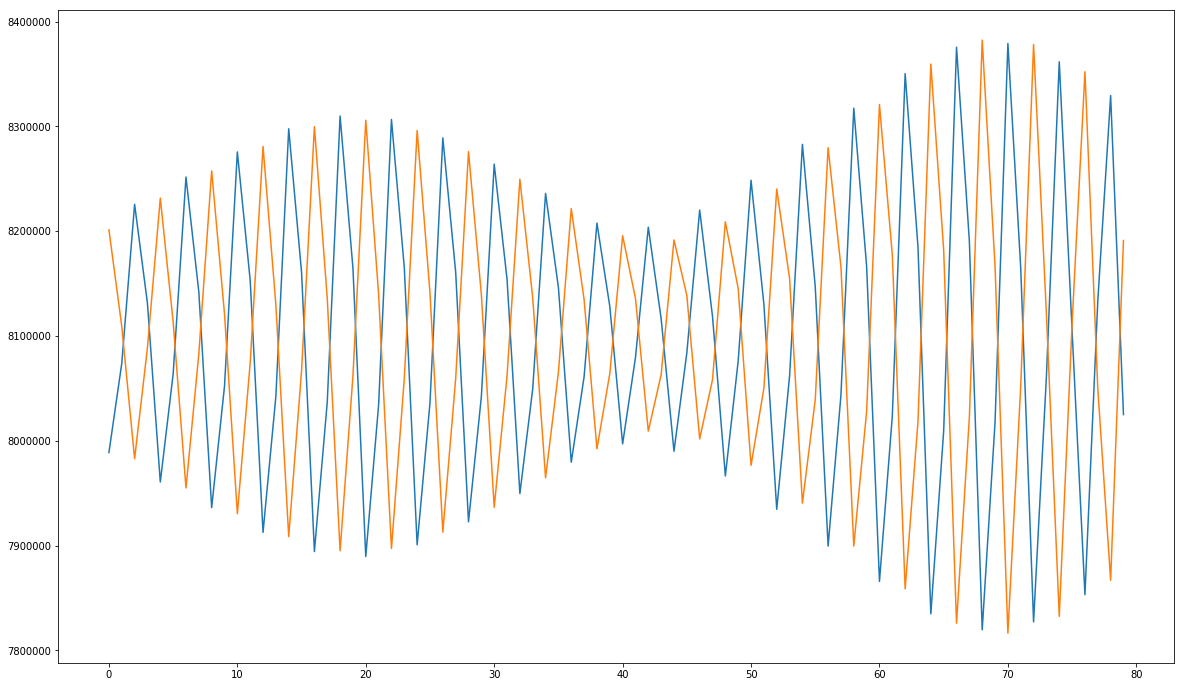

In [913]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)
l = l + 1
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)


In [770]:
lineinfo_cur[100], lineinfo_cur[101]

(1160549.1033076106, 1163347.4488508701)

43.451705388955098

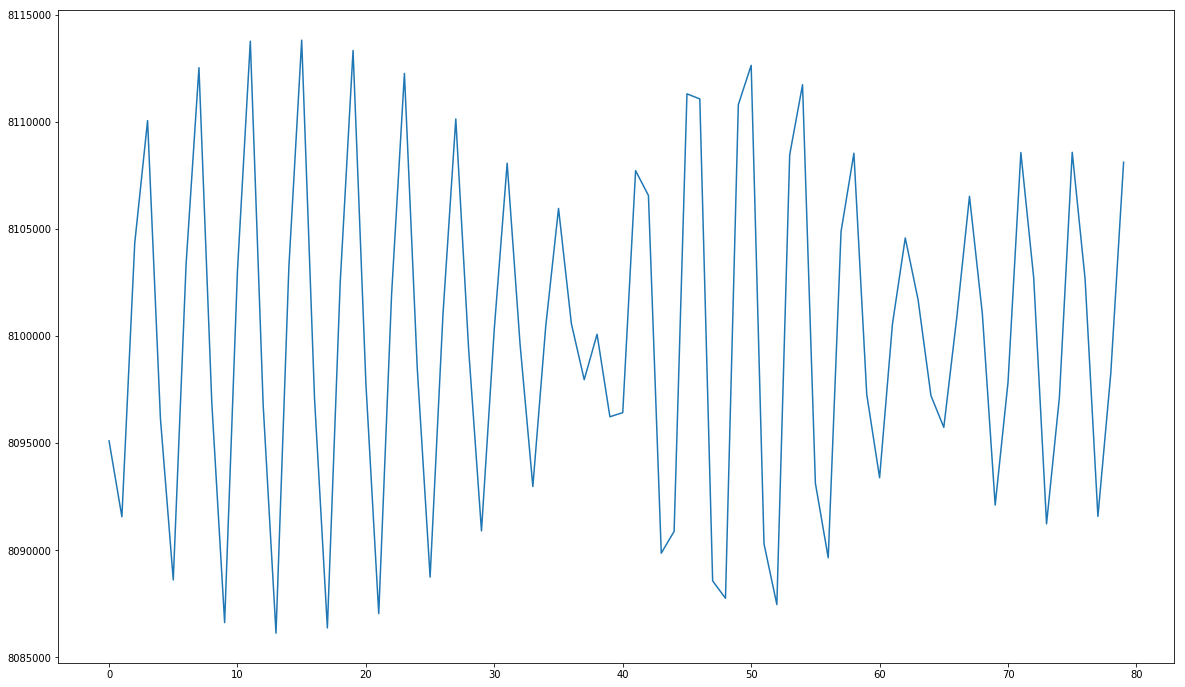

In [914]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
#plt.plot(x)
l = l + 1
y = (x + lines[(910*l)+0:(910*l)+80]) / 2
plt.plot(y)
calcsnr(y[15:50])


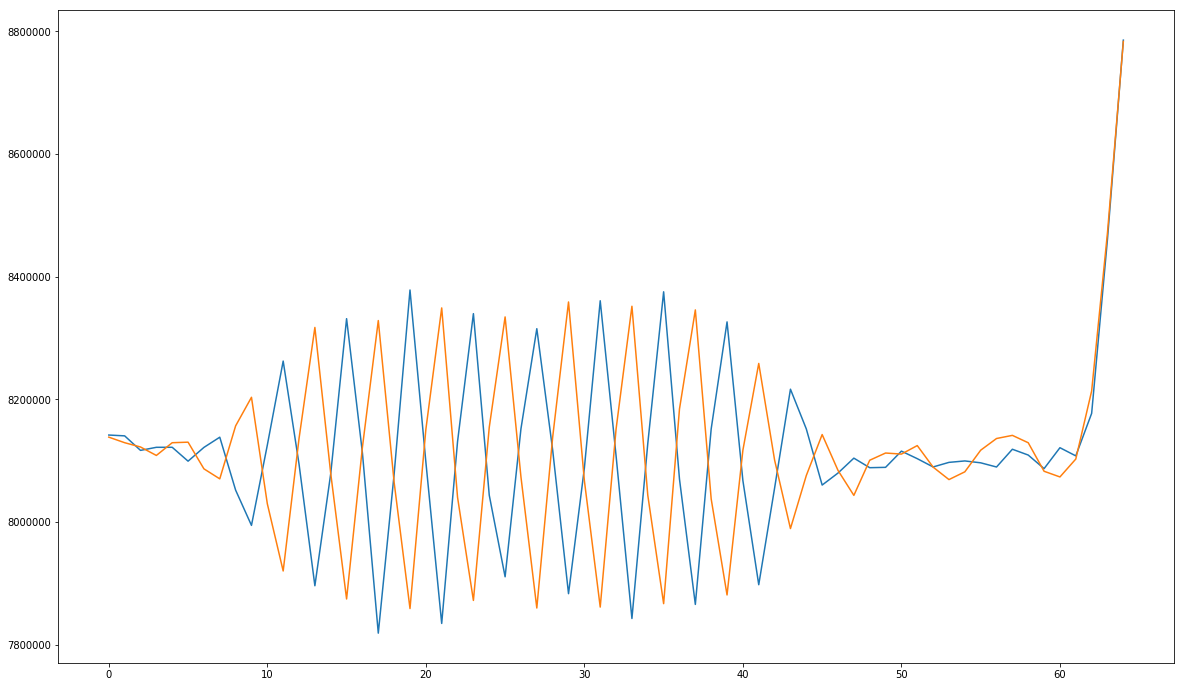

In [137]:
l = 50
x = lines[(910*l)+5:(910*l)+70]
plt.plot(x)
y = lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(y)

22.0131165809


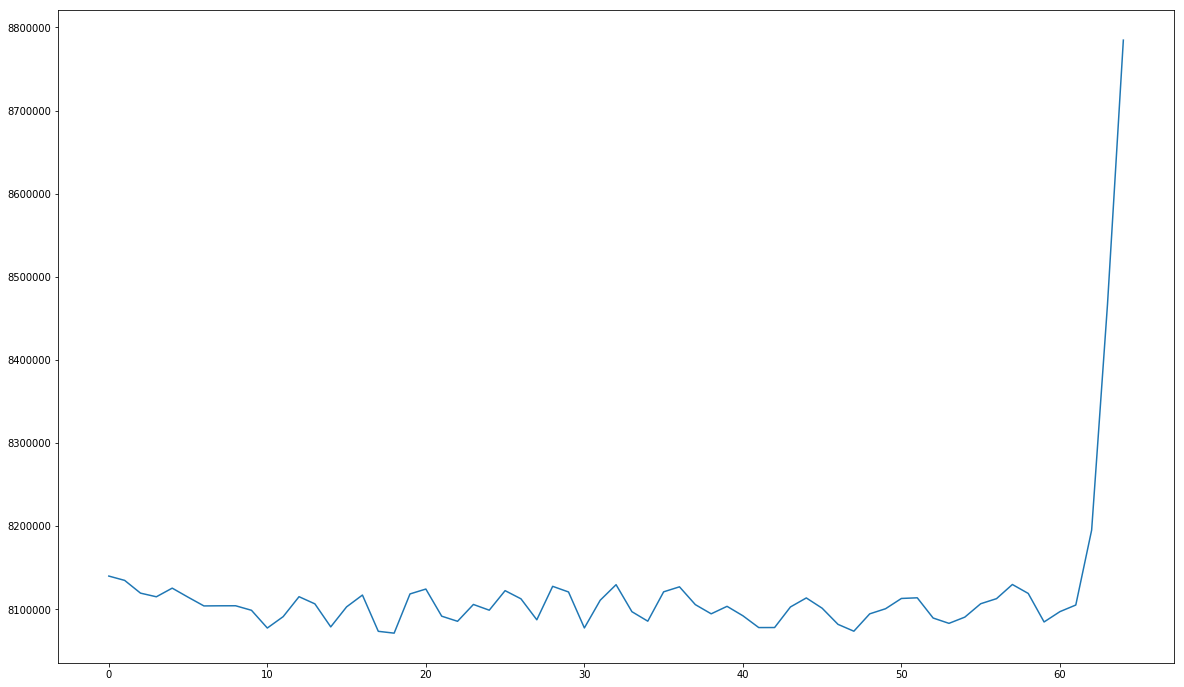

In [138]:
l = 50
x = lines[(910*l)+5:(910*l)+70] + lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(x / 2)
calcsnr(x / 2)

(230230,)
uint8 (253, 910) (253, 910)


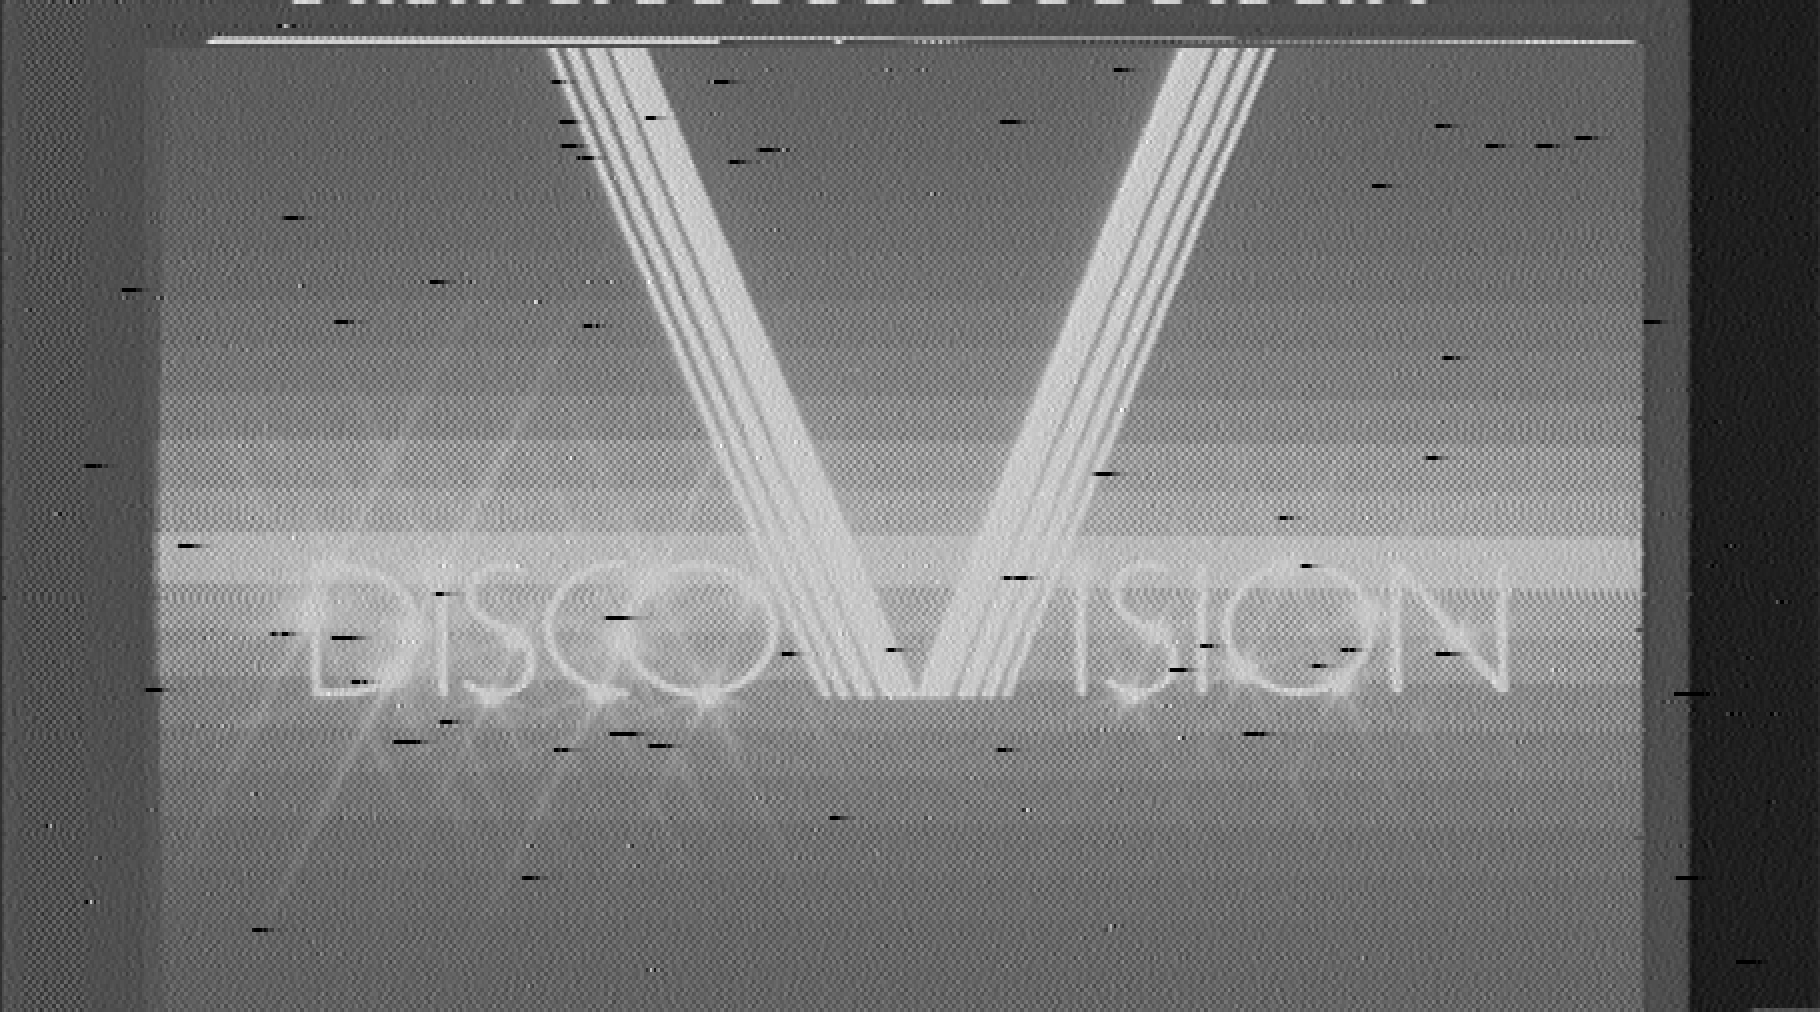

In [35]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [37]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [38]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

e 173
e 219


In [39]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.36511998949632013,
 2.7357543924367347,
 0.76349998963594301,
 149,
 0.25001621551811237)

In [40]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(840.20959013105346,
 845.70162781330214,
 844.23547566598813,
 148,
 0.44573642405298891)

In [41]:
linegaps2 = np.diff(lineinfo2)
linegaps_end = np.diff(lineinfo_cur)

In [42]:
np.mean(linegaps2), np.std(linegaps2), np.min(linegaps2), np.max(linegaps2)

(2794.1198310133477,
 2.2242912880402335,
 2786.4846006617881,
 2799.5613464718917)

In [43]:
np.mean(linegaps_end), np.std(linegaps_end), np.min(linegaps_end), np.max(linegaps_end)

(2794.1198310133477,
 2.2716834575987628,
 2786.4032574766316,
 2800.2662368090241)

In [44]:
filterset['line_px']

2794.0

In [45]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2792.3583034544718, 2792.7066011009738)

In [46]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2791.6145233304705, 2792.2245435791556)

In [47]:
endline[147]

844.04832559894965

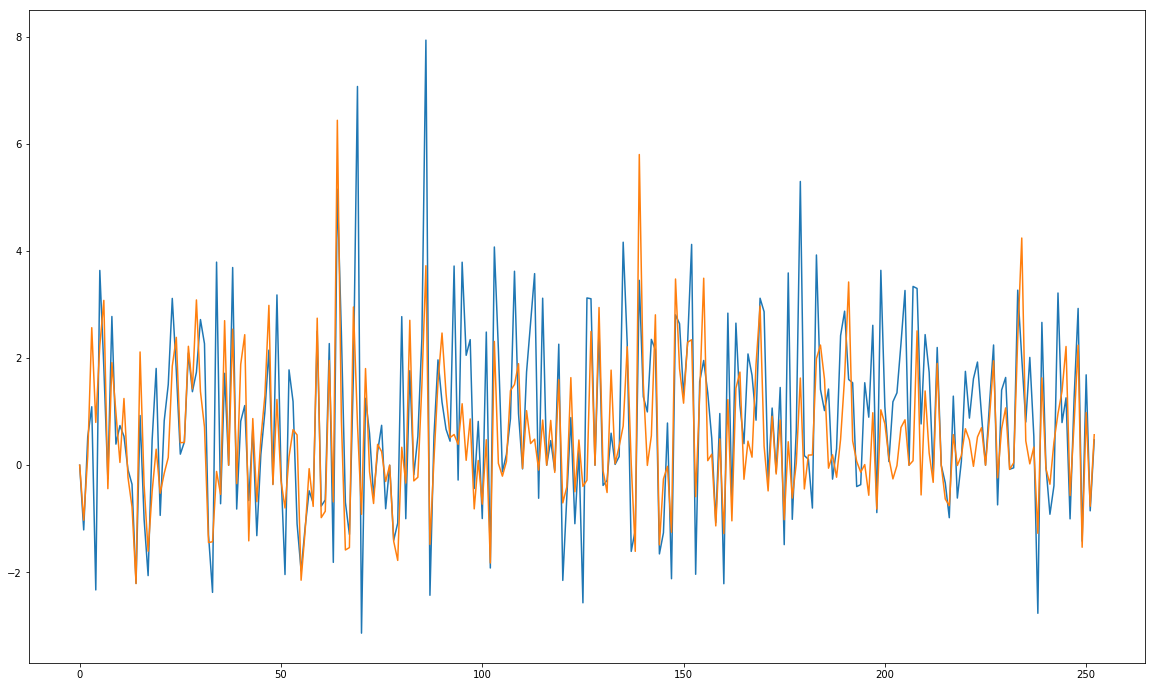

In [48]:
plt.plot(errs[0])
plt.plot(errs[-1])

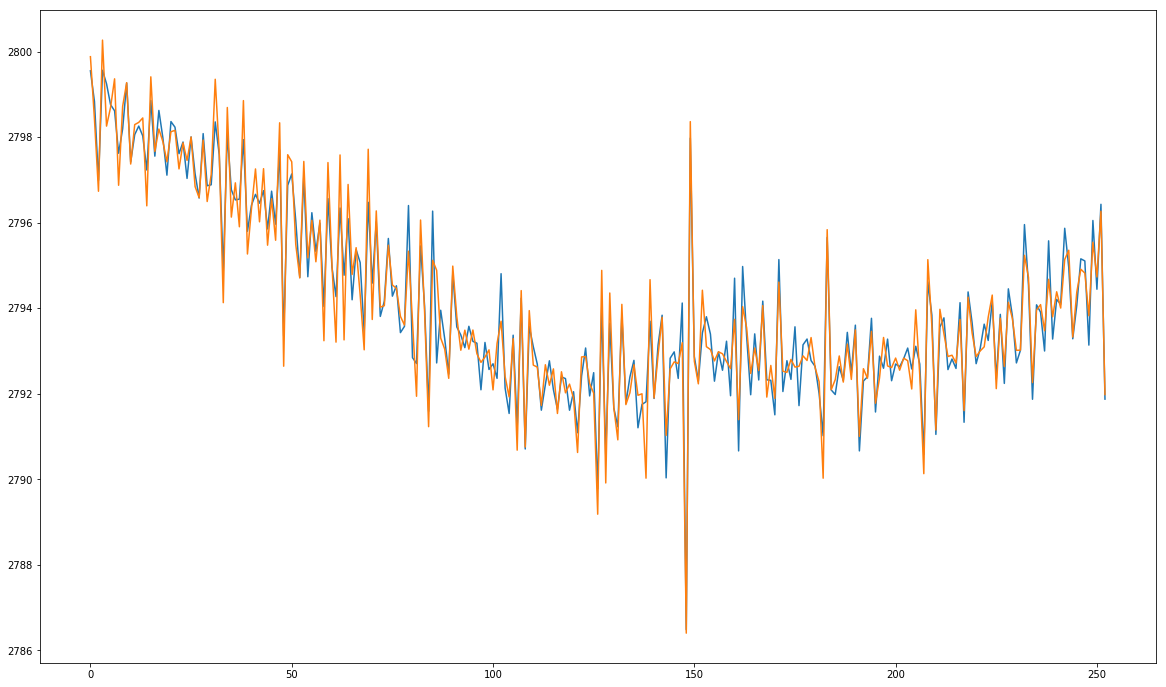

In [49]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))